<a href="https://colab.research.google.com/github/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/1_align_quality-control_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will demonstrate how `gget` can assist the alignment and quality-check of single-cell RNA sequencing data. We will use the single-cell transcriptome of the retinal fovea of a 2-year old macaque published in [Yi, et al. 2021](https://academic.oup.com/nsr/article/8/4/nwaa179/5896967) as an example dataset.  

[Raw data link](https://ngdc.cncb.ac.cn/gsa/browse/CRA002680/CRR138429)

___

Install `gget` from dev branch of the repository (only necessary until next release):

In [ ]:
!git clone -b dev --single-branch https://github.com/lauraluebbert/gget.git -q
!pip install mysql-connector-python -q
!cd gget && pip install . -q

     |████████████████████████████████| 37.6 MB 1.3 MB/s 
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 128 kB 4.9 MB/s 


Install and import packages:

In [ ]:
!pip install anndata scanpy==1.7.2 matplotlib==3.1.3 leidenalg -q
%config InlineBackend.figure_format = 'retina'

import gget

import anndata
import numpy as np
import scanpy as sc

# Change the directory to the scRNAseq_workflow folder for ease
import os
os.chdir("/content/gget/examples/scRNAseq_workflow")

# Custom plotting functions
import funcs

     |████████████████████████████████| 96 kB 2.3 MB/s 
     |████████████████████████████████| 10.3 MB 16.6 MB/s 
     |████████████████████████████████| 13.1 MB 33.1 MB/s 
     |████████████████████████████████| 1.3 MB 40.0 MB/s 
     |████████████████████████████████| 88 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 
     |████████████████████████████████| 3.1 MB 35.9 MB/s 
     |████████████████████████████████| 63 kB 810 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


25 Apr 2022 18:18:33 INFO NumExpr defaulting to 2 threads.


___

#### Code to download and process raw data 
The aligned matrix is also provided in the repository since the data download and alignment takes a 1-2 hours.

Download raw data:

In [ ]:
# !cd data && wget ftp://download.big.ac.cn/gsa/CRA002680/CRR138429/CRR138429_f1.fastq.gz
# !cd data && wget ftp://download.big.ac.cn/gsa/CRA002680/CRR138429/CRR138429_r2.fastq.gz

Pipe `gget` into [`kb-python`](https://www.kallistobus.tools/) to build an index using the latest reference genome from Ensembl:

In [ ]:
# !pip install kb-python -q
# !kb ref -i reference/index.idx -g reference/t2g.txt -f1 reference/fasta.fa $(gget ref -s macaca_mulatta --which dna,gtf --ftp)

Pseudoalignment and counting using [`kb-python`](https://www.kallistobus.tools/):

In [ ]:
# !kb count --filter bustools \
# -i reference/index.idx \
# -g reference/t2g.txt \
# -x 10xv2 \
# --h5ad -t 8 -o "kb_CRR138429" \
# data/CRR138429_f1.fastq.gz \
# data/CRR138429_r2.fastq.gz

Split h5ad file into smalles ones for storage on Github:

In [ ]:
# # Split h5ad file into smaller ones
# !split data/counts_unfiltered/adata.h5ad -b 100m
# # Remove original large file
# !rm data/counts_unfiltered/adata.h5ad

___
# `gget.ref` to fetch the latest reference genome and metadata

Search for "macaca" reference genomes in the latest Ensembl release.

In [ ]:
!gget ref -l | grep macaca

25 Apr 2022 18:18:36 INFO NumExpr defaulting to 2 threads.
25 Apr 2022 18:18:38 INFO Fetching available genomes in Ensembl release 106 (latest).
macaca_nemestrina
macaca_mulatta
macaca_fascicularis


There are 3 genomes available: macaca_mulatta, macaca_nemestrina and macaca_fascicularis. The data we are using here comes from *Macaca mulatta*. Let's take a look a the metadata assocaited with the latest *Macaca mulatta* reference genome.

In [ ]:
# Info on the latest reference genome
!gget ref -s macaca_mulatta

25 Apr 2022 18:18:40 INFO NumExpr defaulting to 2 threads.
25 Apr 2022 18:18:43 INFO Fetching reference information for macaca_mulatta from Ensembl release: 106.
{
    "macaca_mulatta": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/fasta/macaca_mulatta/cdna/Macaca_mulatta.Mmul_10.cdna.all.fa.gz",
            "ensembl_release": 106,
            "release_date": "28-Feb-2022",
            "release_time": "16:56",
            "bytes": "31197949"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/fasta/macaca_mulatta/dna/Macaca_mulatta.Mmul_10.dna.toplevel.fa.gz",
            "ensembl_release": 106,
            "release_date": "21-Feb-2022",
            "release_time": "10:31",
            "bytes": "872921950"
        },
        "annotation_gtf": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/gtf/macaca_mulatta/Macaca_mulatta.Mmul_10.106.gtf.gz",
            "ensembl_release": 106,
      

___

#### Load the data
We will use the unfiltered data aligned by `kb-python` as described above:

In [ ]:
# Concatenate all split files in the counts_unfiltered folder into a single h5ad file
!cd data/counts_unfiltered/ && cat $(ls) > adata.h5ad

Load h5ad file using `anndata`:

In [ ]:
adata = anndata.read("data/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 525066 × 35432
    var: 'gene_name'

In [ ]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata.var["gene_id"] = adata.var.index.values
adata.var.index = adata.var.gene_name.astype(str) + "_" + adata.var.gene_id.astype(str)
del adata.var["gene_id"]

#### Basic quality control

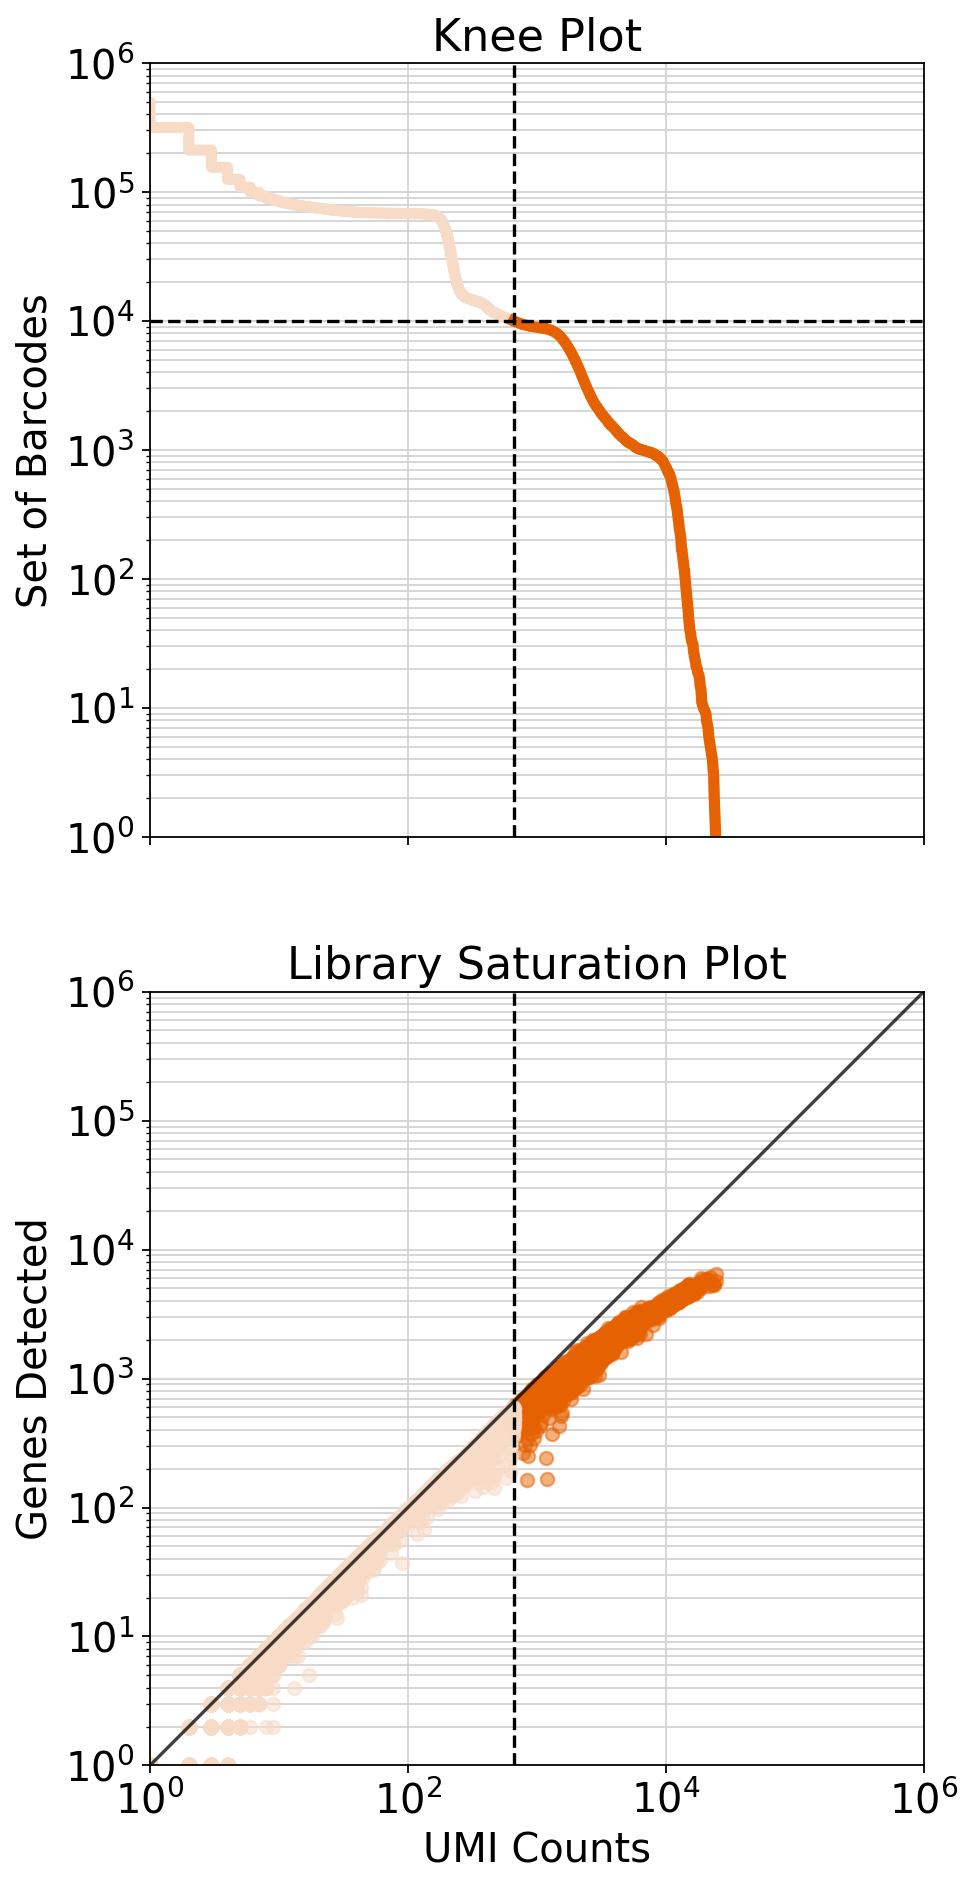

In [ ]:
# Define expected number of cells for filtering cutoff 
expected_num_cells = 10000
# Plot knee and library saturation plot showing filtering cutoff 
funcs.knee_library_sat_plot(adata, expected_num_cells)

___

# `gget.search` to find genes indicative of data quality 

Usually, mitochondrial genes are used for quality control. Mitochondrially encoded genes are labeled with "MT-". Let's see if we have any genes that start with "MT-" in our data:

In [ ]:
adata.var[adata.var.gene_name.str.startswith("MT-")]

,gene_name


It seems like there are no genes that start with "MT-" in our data. Let's use `gget` to query the entire Ensembl database for "MT-" genes for species *Macaca mulatta* to make sure the sequences/annotations are not simply missing from our data/reference:

In [ ]:
gget.search("MT-", "macaca_m")

25 Apr 2022 18:19:00 INFO Fetching results from database: macaca_mulatta_core_106_10
25 Apr 2022 18:19:02 INFO Query time: 3.26 seconds
25 Apr 2022 18:19:02 INFO Matches found: 0


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url


It seems like there is no mitochondrial genome available for *Macaca mulatta*, as if often the case for non-model organisms. However, we can use `gget` to find apoptosis-inducing genes which we can instead use for the quality control:

In [ ]:
qc_df = gget.search(["apoptosis", "inducing"], "macaca_m", andor="and")
# Custom function to wrap columns for easier reading in Colab
funcs.pretty_print(qc_df, ["ensembl_description", "ext_ref_description", "url"])

25 Apr 2022 18:19:17 INFO Fetching results from database: macaca_mulatta_core_106_10
25 Apr 2022 18:19:18 INFO Query time: 2.28 seconds
25 Apr 2022 18:19:18 INFO Matches found: 6


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url
0,ENSMMUG00000004685,NAIF1,nuclear apoptosis inducingfactor 1 [Source:VGNCSymbol;Acc:VGNC:75021],nuclear apoptosis inducingfactor 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000004685
1,ENSMMUG00000004954,AIFM1,apoptosis inducing factormitochondria associated 1[Source:VGNCSymbol;Acc:VGNC:69820],apoptosis inducing factormitochondria associated 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000004954
2,ENSMMUG00000006392,AIFM2,apoptosis inducing factormitochondria associated 2[Source:VGNCSymbol;Acc:VGNC:69666],apoptosis inducing factormitochondria associated 2,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000006392
3,ENSMMUG00000020478,AIFM3,apoptosis inducing factormitochondria associated 3[Source:VGNCSymbol;Acc:VGNC:69709],apoptosis inducing factormitochondria associated 3,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000020478
4,ENSMMUG00000044552,BLCAP,BLCAP apoptosis inducingfactor [Source:VGNCSymbol;Acc:VGNC:84546],BLCAP apoptosis inducingfactor,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000044552
5,ENSMMUG00000052518,SIVA1,SIVA1 apoptosis inducingfactor [Source:HGNCSymbol;Acc:HGNC:17712],SIVA1 apoptosis inducingfactor,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000052518


#### Overlay fraction of QC gene counts with library saturation plot

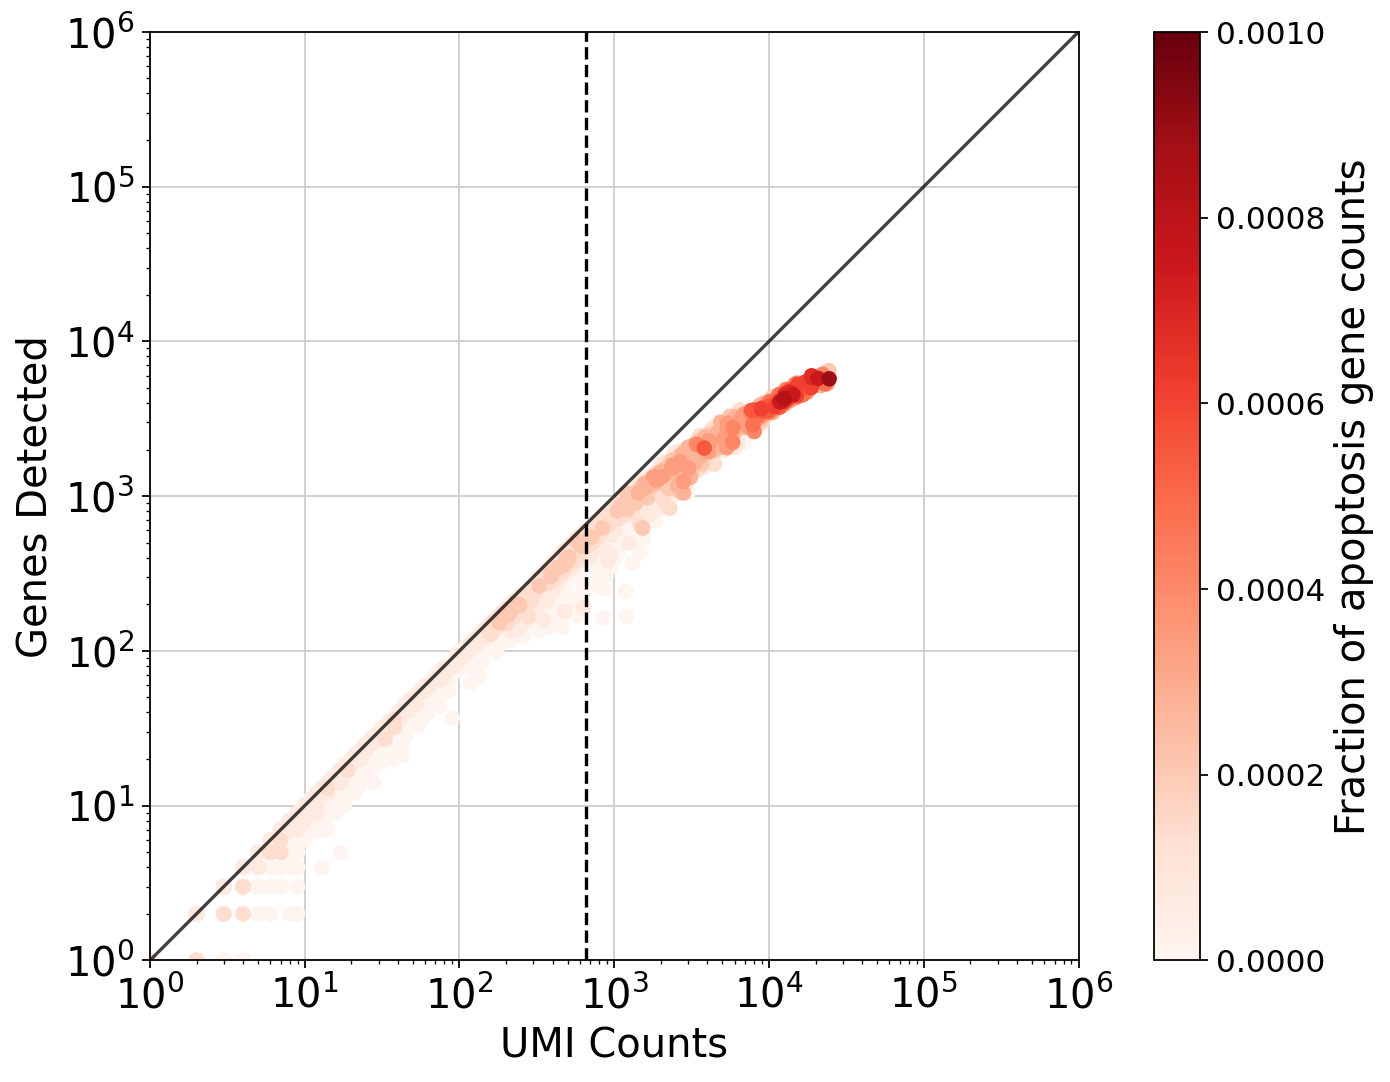

In [ ]:
# Find the IDs in our dataset
qc_genes = funcs.find_ids(adata, qc_df["ensembl_id"].values)
# Overlay fraction of counts with library saturation plot
funcs.library_sat_gene_fraction(adata, qc_genes, gene_type="apoptosis", expected_num_cells=expected_num_cells)

Ideally, the highest fractions of quality control genes should be expressed to the left of the filter line, meaning that the cells with a high expression of apoptosis-inducing genes will be filtered out. Here, we observe that the highest fractions are expressed in the data we will keep. However, since the fractions are extremely low and seem to correlate with the number of UMI counts/genes detected, we can conclude that the expression of apoptosis inducing genes is low overal and evenly distributed across all cells, only increasing with sequencing depth.  

___

#### Code to create the filtered, normalized and clustered matrix we will use in the second part of the analysis
Since each clustering run can create slightly different clusters, we recommend not running the code below and instead using the provided matrix. Otherwise the celltype assignment in notebook #2 will have to be adjusted to the new clusters.

Filter cells based on minimum number of UMI counts from knee plot:

In [ ]:
# knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
# min_umi = knee[expected_num_cells]
# print("The minimum number of UMI counts based on the knee plot is: " + str(min_umi))

# # Removes cells with less than min_umi umi counts
# adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > min_umi]

# # Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
# adata.obs['n_counts_processed'] = adata.X.sum(axis=1)

# # Create copy of raw count (after basic filtering)
# adata.raw = adata.copy()

# adata

Normalization:

In [ ]:
# # CP10k normalization
# sc.pp.normalize_total(adata, target_sum=10**4) 
# # log(expression + 1)
# sc.pp.log1p(adata) # log(expression + 1)

Annotate highly variable genes:

In [ ]:
# sc.pp.highly_variable_genes(adata)
# # sc.pl.highly_variable_genes(adata)

Clustering:

In [ ]:
# # Define number of nearest neighbours
# n_neighbors = 20
# n_pcs=10

In [ ]:
# # Perform PCA on just the highly variable genes
# sc.tl.pca(adata, use_highly_variable=True)

In [ ]:
# # Find nearest neighbors
# sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

# # Leiden clustering on the neighboorhood graph
# sc.tl.leiden(adata, random_state=0)

Save matrix:

In [ ]:
# adata.write("data/macaque_norm_clustered.h5ad")
# # Split data for storage on Github
# !split data/macaque_norm_clustered.h5ad -b 100m
# # Remove original large file
# !rm data/macaque_norm_clustered.h5ad